**[CRP-01]**

Import modules.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy.stats import poisson
matplotlib.rcParams['font.size'] = 12

**[CRP-02]**

Define the CarRental class.

In [0]:
class CarRental:
  def __init__(self, size=20,
               fst_rent_mean=3, snd_rent_mean=4,
               fst_ret_mean=3, snd_ret_mean=2):
    self.size = size
    self.fst_rent_mean = fst_rent_mean
    self.snd_rent_mean = snd_rent_mean    
    self.fst_ret_mean = fst_ret_mean
    self.snd_ret_mean = snd_ret_mean
    self.states = [(fst, snd) for fst in range(size+1) for snd in range(size+1)]

    self.value = {}
    for s in self.states:
      self.value[s] = 0

    self.policy = {}
    for s in self.states:
      self.policy[s] = 0

    self.precalc_r = {}
    self.precalc_p = {}

**[CRP-03]**

Define a function to show results (state values and an action policy).

In [0]:
def show_result(car_rental):
  fig = plt.figure(figsize=(10, 16))

  value = np.zeros((car_rental.size+1, car_rental.size+1), dtype=int)
  policy = np.zeros((car_rental.size+1, car_rental.size+1), dtype=int)
  for s in car_rental.states:
    (fst, snd) = s
    value[fst][snd] = int(car_rental.value[s])
    policy[fst][snd] = car_rental.policy[s]

  subplot = fig.add_subplot(2, 1, 1) 
  ax = sns.heatmap(value, cbar=False, annot=True, fmt='d', cmap='coolwarm', ax=subplot)
  ax.set(title='Value', ylabel='Cars at the 1st shop', xlabel='Cars at the 2nd shop')
  ax.invert_yaxis()
 
  subplot = fig.add_subplot(2, 1, 2)
  subplot.set_title('Policy')
  ax = sns.heatmap(policy, cbar=False, annot=True, cmap='coolwarm', ax=subplot)
  ax.set(title='Policy', ylabel='Cars at the 1st shop', xlabel='Cars at the 2nd shop')
  ax.invert_yaxis()

**[CRP-04]**

Define a function to provide the PMF of poisson distribution.

In [0]:
def memoize(f):
  cache = {}
  def helper(*args):
    if args not in cache:
      cache[args] = f(*args)
    return cache[args]
  return helper

@memoize
def _poisson_pmf(n, mean):
  return poisson.pmf(n, mean)
  
@memoize
def poisson_pmf(n, n_max, mean):
  if n > n_max:
    return 0
  if n == n_max:
    return 1-sum([_poisson_pmf(n, mean) for n in range(n_max)])
  return _poisson_pmf(n, mean)

**[CRP-05]**

Define a function to conduct precalculations.

In [0]:
def precalc(car_rental):
  size = car_rental.size
  fst_rent_mean = car_rental.fst_rent_mean
  snd_rent_mean = car_rental.snd_rent_mean    
  fst_ret_mean = car_rental.fst_ret_mean
  snd_ret_mean = car_rental.snd_ret_mean  

  c = 0
  for s in car_rental.states:
    if c % size == 0:
      print('.', end='')
    c += 1

    (_fst, _snd) = s
    for a in range(-min(_snd, 5), min(_fst, 5)+1):
      car_rental.precalc_r[(s, a)] = 0
      (fst, snd) = s
      fst -= a # Moving cars
      snd += a # Moving cars

      for fst_rent in range(fst+1):
        # p(fst_rent)
        prob1 = poisson_pmf(fst_rent, fst, fst_rent_mean)
        
        for snd_rent in range(snd+1):
          # p(fst_rent) * p(snd_rent)
          prob2 = prob1 * poisson_pmf(snd_rent, snd, snd_rent_mean)
          r = -2 * abs(a) + 10 * (fst_rent + snd_rent)

          for fst_ret in range(size-(fst-fst_rent)+1):
            # p(fst_rent) * p(snd_rent) * p(fst_ret)
            prob3 = prob2 * poisson_pmf(fst_ret, size-(fst-fst_rent), fst_ret_mean)

            for snd_ret in range(size-(snd-snd_rent)+1):
              # p(fst_rent) * p(snd_rent) * p(fst_ret) * p(snd_ret)
              prob = prob3 * poisson_pmf(snd_ret, size-(snd-snd_rent), snd_ret_mean)
              s_new = (fst - fst_rent + fst_ret, snd - snd_rent + snd_ret)

              car_rental.precalc_r[(s, a)] += prob * r

              if (s, a, s_new) not in car_rental.precalc_p.keys():
                car_rental.precalc_p[(s, a, s_new)] = 0
              car_rental.precalc_p[(s, a, s_new)] += prob

  print('\n')

**[CRP-06]**

Define a function to obtain action-state values.

In [0]:
def get_q_value(car_rental, s, a, gamma=0.9):
  q = car_rental.precalc_r[(s, a)]
  for s_new in car_rental.states:
    q += car_rental.precalc_p[(s, a, s_new)] * gamma * car_rental.value[s_new]
  return q

**[CRP-07]**

Define a function to update the greedy policy for a spedific state.

In [0]:
def policy_update(car_rental, s):
  q_max = -10**10
  a_best = None
  (_fst, _snd) = s
  for a in range(-min(_snd, 5), min(_fst, 5)+1):
    q = get_q_value(car_rental, s, a)
    if q > q_max:
      q_max = q
      a_best = a

  car_rental.policy[s] = a_best

  return q_max

**[CRP-08]**

Define a function to apply the value iteration algorithm.

In [0]:
def value_iteration(car_rental, delta=0.1):
  while True:
    delta_max = 0
    print('.', end='')
    for s in car_rental.states:
      v_new = policy_update(car_rental, s)
      delta_max = max(delta_max, abs(car_rental.value[s]-v_new))
      car_rental.value[s] = v_new

    if delta_max < delta:
      print('\n')
      break

**[CRP-09]**

Create an instance of the CarRental class.

In [0]:
car_rental = CarRental()

**[CRP-10]**

Execute the precalculation.

In [0]:
%%time
precalc(car_rental)

.......................

CPU times: user 3min 39s, sys: 914 ms, total: 3min 39s
Wall time: 3min 40s


**[CRP-11]**

Apply the value iteration algorithm.

In [0]:
%%time
value_iteration(car_rental)

....................................

CPU times: user 1min 19s, sys: 51.1 ms, total: 1min 19s
Wall time: 1min 19s


**[CRP-12]**

Show results.

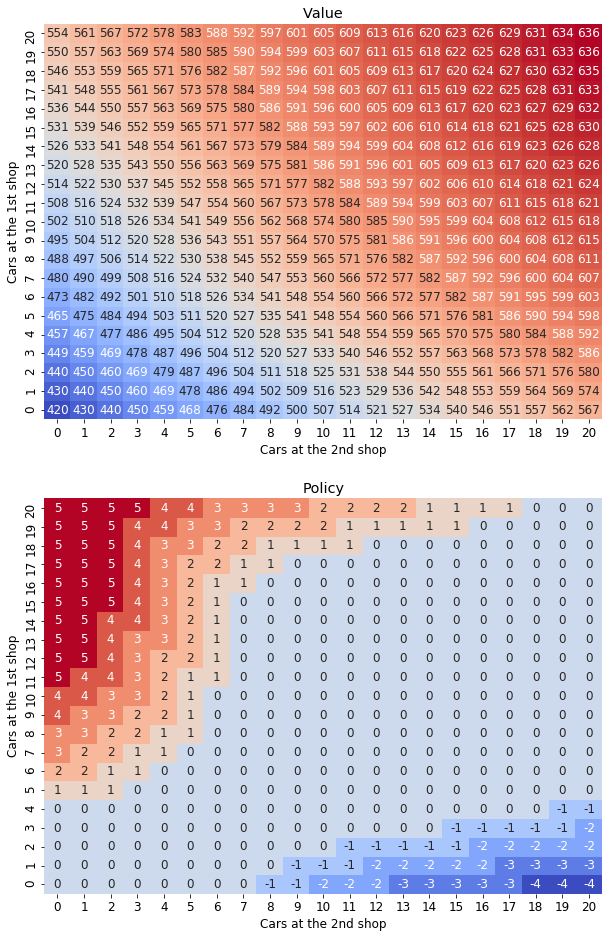

In [0]:
show_result(car_rental)